In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading the users, ratings and movies into dataframes.

In [2]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('/content/drive/MyDrive/DataMining/ml-1m/users.dat', sep='::', header=None, names=unames, engine='python')

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('/content/drive/MyDrive/DataMining/ml-1m/ratings.dat', sep='::', header=None, names=rnames, engine='python')

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('/content/drive/MyDrive/DataMining/ml-1m/movies.dat', sep='::', header=None, names=mnames, engine='python', encoding='latin-1')

In [3]:
#Viewing the first five entries of the users dataframe
users[:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
#Viewing the first five entries of the ratings dataframe
ratings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
#Viewing the first five entries of the movies dataframe
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
#Merging the dataframes to form a new dataframe that shows users, ratings and movies combined together
data = pd.merge(pd.merge(ratings, users), movies)
data.head(10)

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
5,18,1193,4,978156168,F,18,3,95825,One Flew Over the Cuckoo's Nest (1975),Drama
6,19,1193,5,982730936,M,1,10,48073,One Flew Over the Cuckoo's Nest (1975),Drama
7,24,1193,5,978136709,F,25,7,10023,One Flew Over the Cuckoo's Nest (1975),Drama
8,28,1193,3,978125194,F,25,1,14607,One Flew Over the Cuckoo's Nest (1975),Drama
9,33,1193,5,978557765,M,45,3,55421,One Flew Over the Cuckoo's Nest (1975),Drama


##Preprocessing the data

In [7]:
#Splitting production_year from the title in the entire dataframe
data["production_year"] = data["title"].str[-5:-1].astype(int)

In [8]:
#Splitting different genres from the clustered ones in the entire dataframe
data['genre'] = data['genres'].str.split("|")

In [9]:
data_modified = data.explode('genre')

In [10]:
#Keeping in place data such that the genres are now separated
data_modified['genres'] = data_modified['genre']
data_modified.drop(['genre'], axis = 1, inplace = True)

In [11]:
data_modified

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres,production_year
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama,1975
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama,1975
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama,1975
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama,1975
...,...,...,...,...,...,...,...,...,...,...,...
1000206,5780,2845,1,958153068,M,18,17,92886,White Boys (1999),Drama,1999
1000207,5851,3607,5,957756608,F,18,20,55410,One Little Indian (1973),Comedy,1973
1000207,5851,3607,5,957756608,F,18,20,55410,One Little Indian (1973),Drama,1973
1000207,5851,3607,5,957756608,F,18,20,55410,One Little Indian (1973),Western,1973


In [12]:
data_modified.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'gender', 'age',
       'occupation', 'zip', 'title', 'genres', 'production_year'],
      dtype='object')

##Question One


1. [10 pts] An aggregate on the number of rating done for each particular genre, e.g.,
Action, Adventure, Drama, Science Fiction, ...

In [13]:
count_genres = dict(data_modified['genres'].value_counts())
count_genres = pd.DataFrame(list(count_genres.items()), columns = ['genre', 'count_of_ratings'])

In [14]:
count_genres

,genre,count_of_ratings
0,Comedy,356580
1,Drama,354529
2,Action,257457
3,Thriller,189680
4,Sci-Fi,157294
5,Romance,147523
6,Adventure,133953
7,Crime,79541
8,Horror,76386
9,Children's,72186


In [15]:
#count of ratings and split genres
#mean_ratings = data_modified.groupby(['genres']).rating.mean().sort_values(ascending=False)

In [16]:
#Viewing the top 5 rated genres (by count)
count_genres[:5]

,genre,count_of_ratings
0,Comedy,356580
1,Drama,354529
2,Action,257457
3,Thriller,189680
4,Sci-Fi,157294


##Question Two

2. [5 pts] The top 5 ranked genres by women on most number of rating.

In [17]:
#count of ratings 
top_female_ratings = data_modified[data_modified['gender'] == 'F']['genres'].value_counts()

In [18]:
top_female_ratings = pd.DataFrame(list(top_female_ratings.items()), columns = ['genre', 'count_of_ratings'])

In [19]:
top_female_ratings[:5]

,genre,count_of_ratings
0,Drama,98153
1,Comedy,96271
2,Romance,50297
3,Action,45650
4,Thriller,40308


##Question Three

3. [5 pts] The top 5 ranked genres by men on most number of rating.

In [20]:
#count of ratings 
top_male_ratings = data_modified[data_modified['gender'] == 'M']['genres'].value_counts()

In [21]:
top_male_ratings = pd.DataFrame(list(top_male_ratings.items()), columns = ['genre', 'count_of_ratings'])

In [22]:
top_male_ratings[:5]

,genre,count_of_ratings
0,Comedy,260309
1,Drama,256376
2,Action,211807
3,Thriller,149372
4,Sci-Fi,129894


##Question Four

4. [30 pts] Pick a genre of your choice and provide average movie’s ratings by the following
four time intervals during which the movies were released (a) 1970 to 1979 (b) 1980 to
1989 (c) 1990 to 1999 (d) 2000 to 2009. Also, if you observed any issues with data in
any of these ranges, please mention it.

In [23]:
#Drafting a function to provide average movie's ratings taking in genre and the year range as arguments in the descending order of ratings
def prod_year_rating(genre, prod_year_range):
  data_rating = data_modified[(data_modified.genres.str.contains(genre)) & (data_modified['production_year'] <= prod_year_range[1]) & (data_modified['production_year'] >= prod_year_range[0])]
  mean_ratings = data_rating.groupby(['movie_id']).agg({'title': 'min', 'rating': 'mean'}).sort_values(by = ['rating'], ascending = False)
  return mean_ratings 

In [24]:
#Average movie’s ratings by the following four time intervals during which the movies were released (a) 1970 to 1979
prod_year_rating('Drama', [1970, 1979])

,title,rating
movie_id,,
3607,One Little Indian (1973),5.000000
858,"Godfather, The (1972)",4.524966
1193,One Flew Over the Cuckoo's Nest (1975),4.390725
1221,"Godfather: Part II, The (1974)",4.357565
3470,Dersu Uzala (1974),4.326087
...,...,...
2522,Airport '77 (1977),2.354430
2523,Rollercoaster (1977),2.309524
2536,"Concorde: Airport '79, The (1979)",1.891892


In [25]:
#Average movie’s ratings by the following four time intervals during which the movies were released (b) 1980 to 1989
prod_year_rating('Drama', [1980, 1989])

,title,rating
movie_id,,
1131,Jean de Florette (1986),4.324074
1233,"Boat, The (Das Boot) (1981)",4.302697
2931,Time of the Gypsies (Dom za vesanje) (1989),4.300000
1196,Star Wars: Episode V - The Empire Strikes Back...,4.292977
1172,Cinema Paradiso (1988),4.287805
...,...,...
2254,Choices (1981),2.000000
2742,Ménage (Tenue de soirée) (1986),2.000000
3621,Possession (1981),1.666667


In [26]:
#Average movie’s ratings by the following four time intervals during which the movies were released (b) 1990 to 1999
prod_year_rating('Drama', [1990, 1999])

,title,rating
movie_id,,
989,Schlafes Bruder (Brother of Sleep) (1995),5.000000
53,Lamerica (1994),4.750000
2503,"Apple, The (Sib) (1998)",4.666667
318,"Shawshank Redemption, The (1994)",4.554558
527,Schindler's List (1993),4.510417
...,...,...
2845,White Boys (1999),1.000000
1142,Get Over It (1996),1.000000
1165,"Bloody Child, The (1996)",1.000000


In [27]:
#Average movie’s ratings by the following four time intervals during which the movies were released (b) 2000 to 2009
prod_year_rating('Drama', [2000, 2009])

,title,rating
movie_id,,
3888,Skipped Parts (2000),4.500000
3897,Almost Famous (2000),4.226358
3949,Requiem for a Dream (2000),4.115132
3578,Gladiator (2000),4.106029
3647,Running Free (2000),4.000000
3317,Wonder Boys (2000),3.949597
3916,Remember the Titans (2000),3.924485
3951,Two Family House (2000),3.900000
3408,Erin Brockovich (2000),3.863878


##Question Five

5. [30 pts] A function that given a genre and a rating_range (i.e. [3.5, 4]), returns all
the movies of that genre and within that rating range sorted by average rating. Using
an example, demonstrate that your function works.

In [28]:
def genre_rating(genre, rating_range):
    data_rating = data_modified[(data_modified.genres.str.contains(genre)) & (data_modified['rating'] <= rating_range[1]) & (data_modified['rating'] >= rating_range[0])].groupby(['title']).agg({'rating':'mean'}).sort_values(by = ['rating'], ascending = False)
    return data_rating

In [29]:
genre_rating('Animation', [3, 4])

,rating
title,
"Wrong Trousers, The (1993)",3.856716
"Close Shave, A (1995)",3.844358
Wallace & Gromit: The Best of Aardman Animation (1996),3.820809
"Grand Day Out, A (1992)",3.758929
Toy Story 2 (1999),3.729798
...,...
Digimon: The Movie (2000),3.285714
Space Jam (1996),3.276873
"Return of Jafar, The (1993)",3.210526


6. [20 pts] Present one other statistic, figure, aggregate, or plot that you created using
this dataset, along with a short description of what interesting observations you derived
from it. This question is meant to give you a freehand to explore and present aspects
of the dataset that interests you.

In [30]:
# The number of times a movie has been rated in descending order
data_modified.groupby('title').count()['rating'].sort_values(ascending=False)

title
Star Wars: Episode V - The Empire Strikes Back (1980)    14950
Star Wars: Episode VI - Return of the Jedi (1983)        14415
Star Wars: Episode IV - A New Hope (1977)                11964
Men in Black (1997)                                      10152
Princess Bride, The (1987)                                9272
                                                         ...  
Night Tide (1961)                                            1
Frank and Ollie (1995)                                       1
Make Them Die Slowly (Cannibal Ferox) (1980)                 1
Diebinnen (1995)                                             1
Mutters Courage (1995)                                       1
Name: rating, Length: 3706, dtype: int64

It could be observed that American Beauty had about 3428 ratings closely followed by Start Wars and its different episodes. I could also notice that there were a lot of movies rated only once for eg. Full Speed, Never Met Picasso etc.

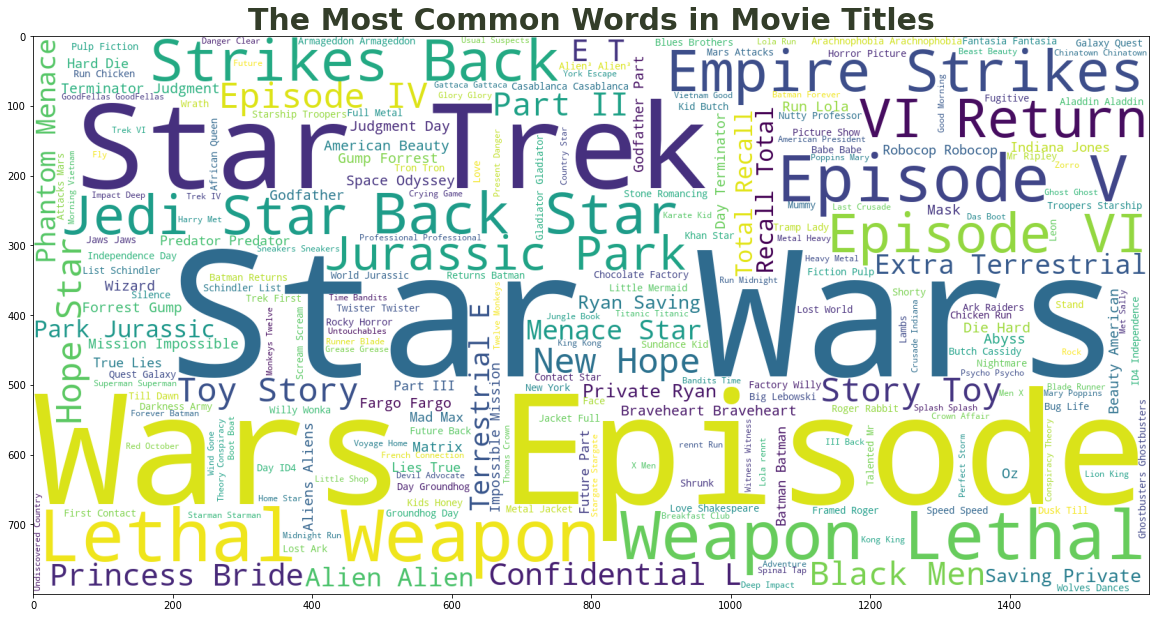

In [31]:
# Plotting a word cloud to check for the most watched movies and also checking for the most common words in movie titles
plt.figure(figsize=(20,20))
plt.title('The Most Common Words in Movie Titles', fontsize=30, weight=600, color='#333d29')
word_cloud = WordCloud(max_words=500, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(data_modified['title']))

plt.imshow(word_cloud)

Complying with the observations in the previous block of code, this word cloud cemented that observation where in Star Wars was known to be rated a lot of times. It is evident through the Word Cloud as well. The other most common words in movie titles as per the count were Star Trek, Jurassic Park etc. 

Text(0.5, 1.0, 'Top 5 Genres in Movies')

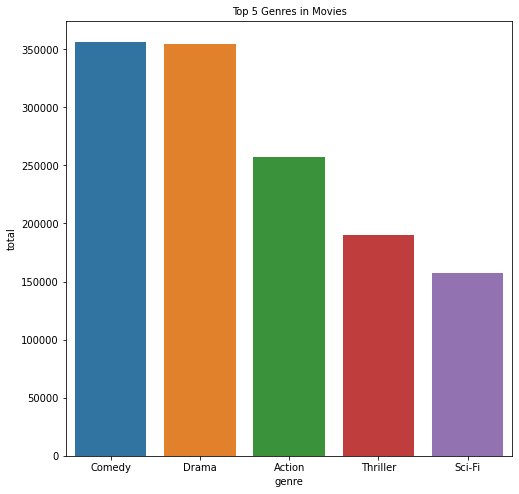

In [32]:
#Viewing the top 5 genres in movies
from matplotlib import pyplot
genres_list = []
for i in data_modified['genres']:
    genres_list.extend(i.split(', '))
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
fig = pyplot.subplots(figsize=(8,8))
ax = sns.barplot(data=df_plot, x='genre', y='total')
ax.set_title('Top 5 Genres in Movies', fontsize=10)

The above bar plot represented the top 5 genres in movies thereby cementing the observations derived from question one. 

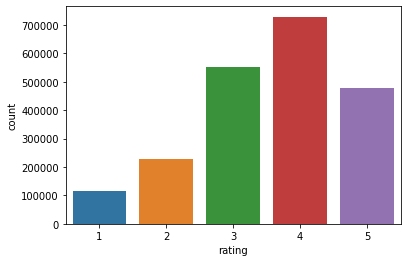

In [33]:
#Getting the count of ratings 
sns.countplot(x = data_modified['rating']);

Most movies had a rating of 4. The rest had a majority of 3 ratings followed by 5, 2 and 1 star. 

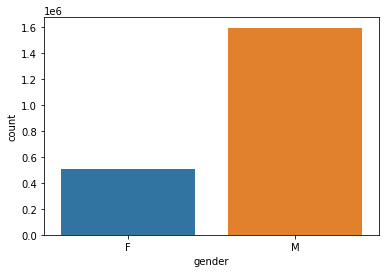

In [34]:
#Getting the number of ratings given by each gender
sns.countplot(x = data_modified['gender']);

The above plot was to notice the number of ratings given by each gender.

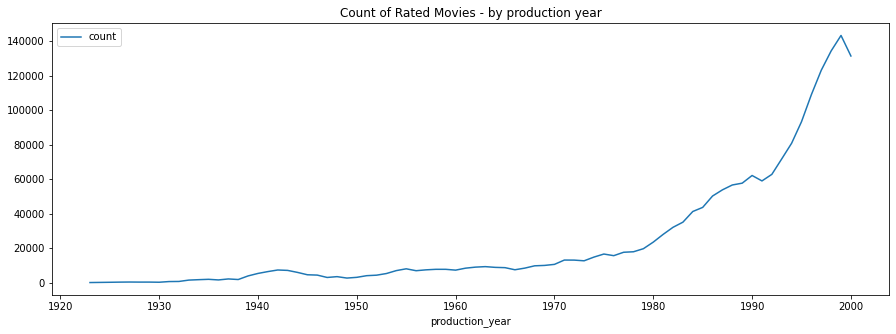

In [35]:
condition = data_modified["production_year"].astype(int) < 2022

prodcount = (data_modified[condition][["production_year", "movie_id"]]
             .groupby("production_year")
             .count()
            )

(prodcount
 .rolling(5).mean().rename(columns={"movie_id":"count"})
 .plot(figsize=(15,5),
       title="Count of Rated Movies - by production year")
)

The above plot was to notice the count of rated movies as per the production year. We notice a steady increase after 1970 till the 2000s where it slowly starts to drop. 

In [36]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain

In [37]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/DataMining/DataMiningAssignmentOne.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/DataMining/DataMiningAssignmentOne.ipynb to pdf
[NbConvertApp] Support files will be in DataMiningAssignmentOne_files/
[NbConvertApp] Making directory ./DataMiningAssignmentOne_files
[NbConvertApp] Making directory ./DataMiningAssignmentOne_files
[NbConvertApp] Making directory ./DataMiningAssignmentOne_files
[NbConvertApp] Making directory ./DataMiningAssignmentOne_files
[NbConvertApp] Making directory ./DataMiningAssignmentOne_files
[NbConvertApp] Writing 90450 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 602023 bytes to /content/drive/MyDrive/DataMining/DataMiningAssignmentOne.pdf
